# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [1]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import scipy
from scipy import linalg
from scipy import signal
import control

# My own script (an interface to the simulator)
import ae353_spacecraft

These intructions are provided by Professor Bretl

Create an instance of the `Simulator` class

There are two optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `seed` (an integer, default `None`) is a seed to initialize the random number generator used by the simulator.

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. 

In [2]:
#seed of 10 was chosen at random
simulator = ae353_spacecraft.Simulator(
    display=False,
    seed=10,
)

# Dynamic Model

In [3]:
# Mass and MOI of base
mb = 6.
Jxb = 10.
Jyb = 10.
Jzb = 16.

# Mass and MOI of each wheel
mw = 1.
Jxw = 0.075
Jyw = 0.075
Jzw = 0.125
lw = 1.1

# Define yaw, pitch, roll yaw angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
lt = sym.nsimplify(lw) * sym.sqrt(2) / 2
T1 = - tau_1 * sym.Matrix([[lt], [0], [lt]])
T2 = - tau_2 * sym.Matrix([[-lt], [0], [lt]])
T3 = - tau_3 * sym.Matrix([[0], [lt], [lt]])
T4 = - tau_4 * sym.Matrix([[0], [-lt], [lt]])
T = T1 + T2 + T3 + T4

# Define MOI of spacecraft and wheels together
Jx = sym.nsimplify(Jxb + 4 * mw * lw**2)
Jy = sym.nsimplify(Jyb + 4 * mw * lw**2)
Jz = sym.nsimplify(Jzb + 4 * mw * lw**2)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

f

Matrix([
[                        (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                     w_y*cos(phi) - w_z*sin(phi)],
[         w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-55*sqrt(2)*tau_1/1484 + 55*sqrt(2)*tau_2/1484 - 150*w_y*w_z/371],
[-55*sqrt(2)*tau_3/1484 + 55*sqrt(2)*tau_4/1484 + 150*w_x*w_z/371],
[                55*sqrt(2)*(-tau_1 - tau_2 - tau_3 - tau_4)/2084]])

### Find A and B matrices

In [4]:
# equilibrium point test
f_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f)
psie = 0.
thetae = 0.
phie = 0.
w_xe = 0.
w_ye = 0.
w_ze = 0.
tau_1e = 0.
tau_2e = 0.
tau_3e = 0.
tau_4e = 0.



#Find A
A_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f.jacobian([psi, theta, phi, w_x, w_y, w_z]))
A = A_num(psie, thetae, phie, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e).astype(float)

#Find B
B_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f.jacobian([tau_1, tau_2, tau_3, tau_4]))
B = B_num(psie, thetae, phie, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e).astype(float)

###  Check for controllability

In [5]:
# Create index variable for loop
n = A.shape[0]

# Initialize W with its first column
W = B

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])

# Check if controllable system
print('The shape of A is')
print(A.shape , '\n')
print('The rank of W_c is')
print(np.linalg.matrix_rank(W), '\n')

if A.shape[0] == np.linalg.matrix_rank(W):
    print('The system is controllable')
else:
    print('The system is not controllable')

The shape of A is
(6, 6) 

The rank of W_c is
6 

The system is controllable


### Implement LQR to find gain matrix K

Please note that the K matrix displayed below is the final K matrix referenced in the application of verification section in our report.

In [6]:
# weight matrix Qc (error)
Q_c = np.diag([1., 1., 1., 1., 1., 1.])
# weight matrix Rc (effort)
R_c = np.eye(B.shape[1])

# cost matrix P_c
P_c = linalg.solve_continuous_are(A, B, Q_c, R_c)

# trivial gain matrix K for theory section
K_trivial = linalg.inv(R_c) @ B.T @ P_c
np.set_printoptions(suppress=True)

###########################################################################

# weight matrix Qc (error)
Q_c = np.diag([1000., 1000., 1500., 1., 1., 1.])
# weight matrix Rc (effort)
R_c = np.eye(B.shape[1])

# cost matrix P_c
P_c = linalg.solve_continuous_are(A, B, Q_c, R_c)

# final gain matrix K for results section
K = linalg.inv(R_c) @ B.T @ P_c
np.set_printoptions(suppress=True)
print("\nThe final gain matrix K is:\n")
print(K)


The final gain matrix K is:

[[-15.8113883   -0.         -27.38612788 -22.86920773  -0.
  -14.56250738]
 [-15.8113883   -0.          27.38612788  22.86920773   0.
  -14.56250738]
 [-15.8113883  -22.36067977  -0.          -0.         -20.66688182
  -14.56250738]
 [-15.8113883   22.36067977   0.           0.          20.66688182
  -14.56250738]]


### Check for asymptotic stabilty

Please note that the eigenvalues displayed below are for the trivial case referenced in the theory section of our report.

In [7]:
# check eigenvalues to ensure asymptotic stabilty for trivial system
F = A - B@K_trivial
s = linalg.eigvals(F)
print('\n The real part of eigenvalues for the trivial system are:\n')
print(s.real.tolist())

if (s.real < 0).all() == True:
    print('\n The eigenvalues of the trivial system are all of negative real part, \
    \n therefore the closed-loop system is indeed asymptotically stable')
else:
    print('\n The eigenvalues of the system are NOT all of negative real part, please refine your Q and R weights')


 The real part of eigenvalues for the trivial system are:

[-0.1967646383667806, -0.1967646383667806, -0.19604995805552827, -0.19604995805552827, -0.19604995805552783, -0.19604995805552783]

 The eigenvalues of the trivial system are all of negative real part,     
 therefore the closed-loop system is indeed asymptotically stable


In [8]:
# check eigenvalues to ensure asymptotic stabilty for final system
F = A - B@K
s = linalg.eigvals(F)

if (s.real < 0).all() == True:
    print('\n The eigenvalues of the final system are all of negative real part, \
    \n therefore the closed-loop system is indeed asymptotically stable')


 The eigenvalues of the final system are all of negative real part,     
 therefore the closed-loop system is indeed asymptotically stable


# Sensor Model

In [9]:
alpha, delta = sym.symbols('alpha, delta')
# Scope radius
r = 0.8 / 2.1
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                       [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

### Find C and D matrices

In [10]:
#loop through stars to find equilibrium locations
for (i, star) in enumerate(simulator.stars):
    alphae = star["alpha"]
    deltae = star["delta"]
    
    #find C matrix
    j_num = sym.lambdify((psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4), g.subs([(alpha, alphae), (delta, deltae)]).jacobian([psi, theta, phi, w_x, w_y, w_z]))
    C_star = j_num(psie, thetae, phie, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e).astype(float)
    
    #Find D matrix
    j_num = sym.lambdify((psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4), g.subs([(alpha, alphae), (delta, deltae)]).jacobian([tau_1, tau_2, tau_3, tau_4]))
    D_star = j_num(psie, thetae, phie, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e).astype(float)
    
    #block matrices together to combine star into one big C and D matrix
    if i == 0:
        C = C_star
        D = D_star
    else:
        C = np.block([[C], [C_star]])
        D = np.block([[D], [D_star]])
        
print(D)
print("Notice D is zero matrix, this makes sense since g is not dependent on torques. More discussion is included in the report.")
   

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Notice D is zero matrix, this makes sense since g is not dependent on torques. More discussion is included in the report.


### Check for observability

In [11]:
# Initialize W with its first column
W = C

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = C @ np.linalg.matrix_power(A, i)
    W = np.block([[W], [col]])

# Check if controllable system
print('The shape of A is')
print(A.shape , '\n')
print('The rank of W_o is')
print(np.linalg.matrix_rank(W.T), '\n')

if A.shape[0] == np.linalg.matrix_rank(W.T):
    print('The system is observable')
else:
    print('The system is not observable')

The shape of A is
(6, 6) 

The rank of W_o is
6 

The system is observable


### Implement eigenvalue placement to find L

Please note that the L matrix displayed below is the final L matrix referenced in the application of verification section in our report.

In [12]:
'''The place_varga function produces the gain matrix L as intended, but displays a warning. 
This code disables it for clarity'''
import warnings
warnings.filterwarnings("ignore")

#trivial eigenvalue placement referenced in theory section
p_trivial = np.array([-1, -1, -1, -1, -1, -1])
L_trivial = (control.place_varga(A.T, C.T, p_trivial)).T

#final eigenvalue placement for results section
p = np.array([-10, -1, -1, -1, -10, -10])
L = (control.place_varga(A.T, C.T, p)).T
print("\nThe final gain matrix L is:\n")
print(L)


The final gain matrix L is:

[[-1.08668304 -0.01639625 -1.07585239  0.         -1.08668304  0.01639625
  -1.07585239  0.         -1.08668304  0.01639625 -1.07585239  0.
  -1.08668304 -0.01639625]
 [ 0.00877246  0.5888918  -0.          0.58875944 -0.00877246  0.5888918
  -0.          0.57561141 -0.00877246  0.5888918  -0.          0.58875944
   0.00877246  0.5888918 ]
 [-0.64928962  0.42889276 -0.64604588  0.         -0.64928962 -0.42889276
  -0.          0.          0.64928962  0.42889276  0.64604588  0.
   0.64928962 -0.42889276]
 [-0.32464481  0.21444638 -0.32302294  0.         -0.32464481 -0.21444638
  -0.          0.          0.32464481  0.21444638  0.32302294  0.
   0.32464481 -0.21444638]
 [ 0.00797496  0.53535619 -0.          0.53523586 -0.00797496  0.53535619
  -0.          0.5232831  -0.00797496  0.53535619 -0.          0.53523586
   0.00797496  0.53535619]
 [-5.43341522 -0.08198124 -5.37926194  0.         -5.43341522  0.08198124
  -5.37926194  0.         -5.43341522  0.08198

### Check for asymptotic stabilty

Please note that the eigenvalues displayed below are for the trivial case referenced in the theory section of our report.

In [13]:
#trivial design for theory section, check if eigenvalues have negative real part to ensure asymptoptic stability.
F = np.block([[A - B@K_trivial, -B@K_trivial],
             [np.zeros((6, 6)), A - L_trivial@C]])
s = linalg.eigvals(F)
print('\n The real part of eigenvalues for the trivial system are:\n')
print(s.real.tolist())

if (s.real < 0).all() == True:
    print('\n The eigenvalues of the trivial system are all of negative real part,\
    \n therefore the closed-loop system is indeed asymptotically stable. \
    \n \n Notice these are the same real part of the eigenvalues from before, demonstrating the separation principle.')
else:
    print('\n The eigenvalues of the system are NOT all of negative real part, please define new eigenvalues')


 The real part of eigenvalues for the trivial system are:

[-0.1967646383667806, -0.1967646383667806, -0.19604995805552838, -0.19604995805552838, -0.1960499580555278, -0.1960499580555278, -0.9999999844328011, -1.0000000155671986, -0.9999999771127086, -1.0000000228872923, -1.0000000000000002, -1.0000000000000002]

 The eigenvalues of the trivial system are all of negative real part,    
 therefore the closed-loop system is indeed asymptotically stable.     
 
 Notice these are the same real part of the eigenvalues from before, demonstrating the separation principle.


In [14]:
#final design for theory section, check if eigenvalues have negative real part to ensure asymptoptic stability.
F = np.block([[A - B@K, -B@K],
             [np.zeros((6, 6)), A - L@C]])
s = linalg.eigvals(F)

if (s.real < 0).all() == True:
    print('\n The eigenvalues of the final system are all of negative real part,\
    \n therefore the closed-loop system is indeed asymptotically stable.')


 The eigenvalues of the final system are all of negative real part,    
 therefore the closed-loop system is indeed asymptotically stable.


# Find positions of star at equilibirum

In [15]:
#loop through stars
for (i, star) in enumerate(simulator.stars):
    
    #extract positions
    alphae = star["alpha"]
    deltae = star["delta"]
    
    #assign position
    position = g.subs([(psi, 0), (theta, 0), (phi, 0), (alpha, alphae), (delta, deltae)])
    position = np.array(position).astype(np.float64).flatten()
    
    #add to list
    if i == 0:
        positions = position
    else:
        positions = np.block([[positions],
                      [position]])

#create correct shape       
positions = positions.flatten()
    

# Define a controller

In [16]:
class Controller:
    def __init__(self, A, B, C, K, L, psie, thetae, phie, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e, positions):
        self.dt = 0.01
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.psie = psie
        self.thetae = thetae
        self.phie = phie
        self.w_xe = w_xe
        self.w_ye = w_ye
        self.w_ze = w_ze
        self.tau_1e = tau_1e
        self.tau_2e = tau_2e
        self.tau_3e = tau_3e
        self.tau_4e = tau_4e
        self.positions = positions
        
        #keep track of state estimate
        self.variables_to_log = ['xhat']
        
    def reset(self):
        #initialize state estimate
        self.xhat = np.array([0., 0., 0., 0., 0., 0.])
        
    
    def run(self, t, star_meas):
        # Find input
        u = - self.K @ self.xhat
        # Find measurement
        y = np.array(star_meas - self.positions)
        # Find state estimate
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ ((self.C @ self.xhat - y)))
        
        # Find actuator command
        tau1 = u[0] + self.tau_1e
        tau2 = u[1] + self.tau_2e
        tau3 = u[2] + self.tau_3e
        tau4 = u[3] + self.tau_4e
        
        # Activate correct wheel
        front_torque = tau1
        back_torque = tau2
        left_torque = tau3
        right_torque = tau4
        
        
        return front_torque, back_torque, left_torque, right_torque

# Loop through 200 simulations

Sensor noise of 0.1

In [17]:
# Create instance of controller
controller = Controller(A, B, C, K, L, psie, thetae, phie, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e, positions)

#inititalize lists to store data
t = []
xhat = []
t_obs = []
yaw_list = []
pitch_list = []
roll_list = []

for i in range(200):
    
    # Reset simulator with specified conditions
    simulator.reset(
        orientation={
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
        },
        angular_velocity={
            'x': 0.,
            'y': 0.,
            'z': 0.,
        },
        scope_noise=0.1,
    )

    # Reset controller
    controller.reset()

    # Run Simulation
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=300.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
        print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
    )
    
    #gather data from simulator
    t_sim = data['t']
    t_end = t_sim[-1]
    t.append(t_end)
    
    t_obs.append(t_sim)
    
    xhat_sim = data['xhat']
    xhat.append(xhat_sim)
    
    yawe1 = data['yaw']
    pitche1 = data['pitch']
    rolle1 = data['roll']
    
    yaw_list.append(yawe1)
    pitch_list.append(pitche1)
    roll_list.append(rolle1)

# Plot results

Sensor noise of 0.1

* Plot time until failure as in report
* Plot RMSE for yaw, pitch, roll as in report
* Plot state estimate vs actual state for yaw, pitch, roll as in report


Average time until failure:  72.2832


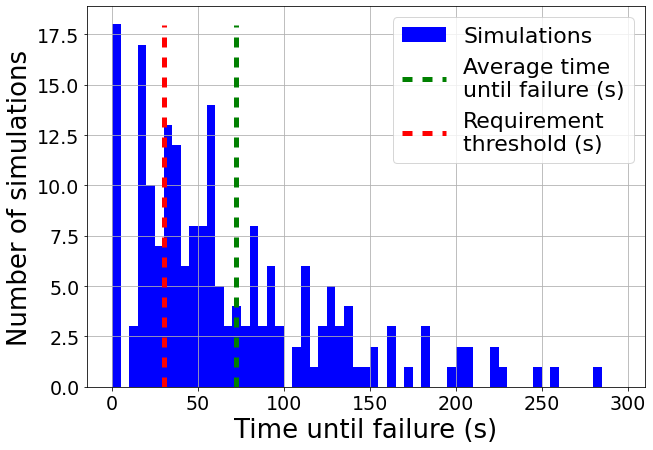

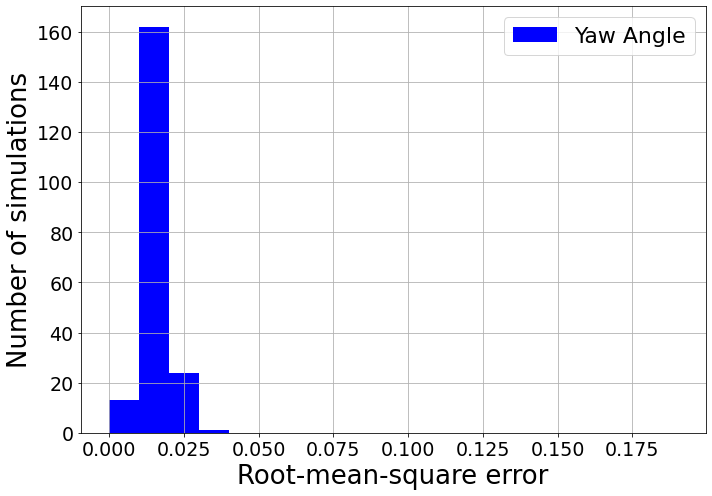

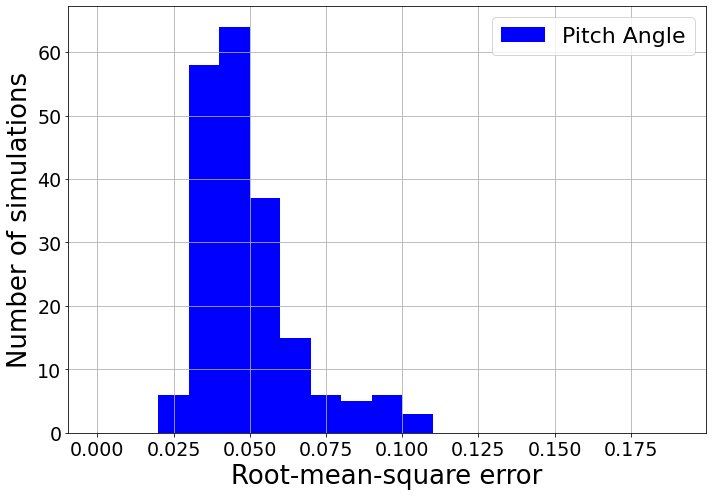

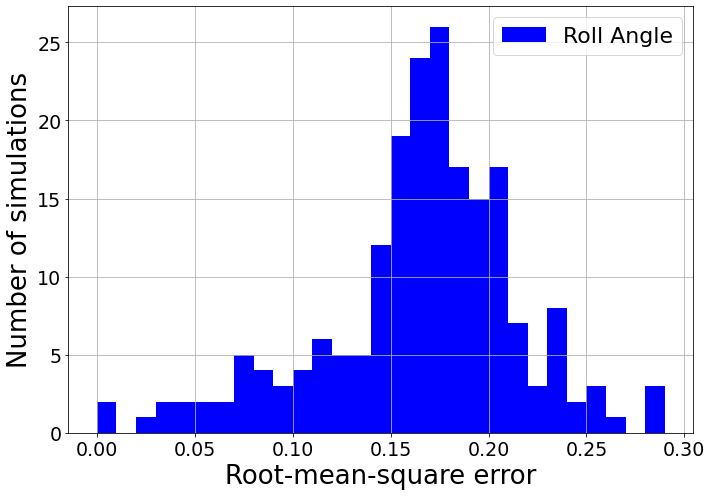

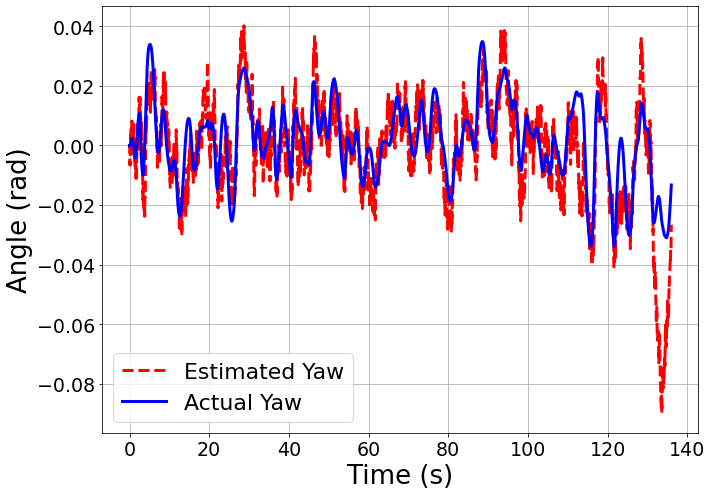

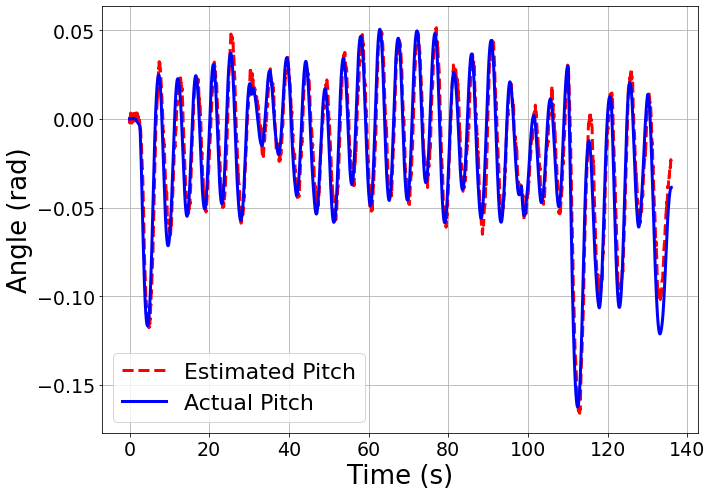

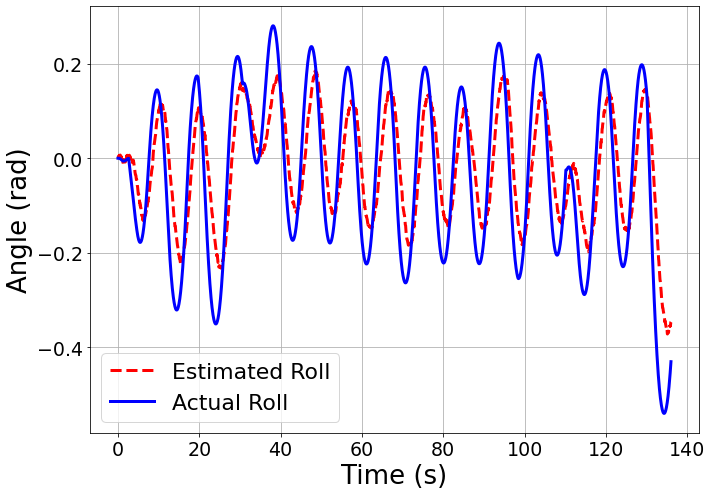

In [18]:
from matplotlib import pyplot as plt
import math
from matplotlib.ticker import FormatStrFormatter


# Creating histogram for time until failure
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(t, bins = np.arange(0, 300, 5), color = 'b',label = 'Simulations')
ax.set_xlabel("Time until failure (s)", fontsize=26)
ax.set_ylabel("Number of simulations", fontsize=26)
ax.tick_params(labelsize=19)

# Find average time until failure
mean = np.mean(t)
print("Average time until failure: ", mean)

# Plot average time until failure
ax.axvline(x = mean, ymin = 0, ymax = 0.95, linestyle = (0,(2,2)), color = 'g', linewidth = 5, label = 'Average time\nuntil failure (s)')

# Plot requirement of 30 seconds
ax.axvline(x = 30, ymin = 0, ymax = 0.95, color = 'r', linestyle = (0,(2,2)), linewidth = 5, label = 'Requirement\nthreshold (s)' % mean)

ax.legend(loc='best', fontsize = 22)
ax.grid()
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('Time_Until_Failure.png', facecolor='white', transparent=False)
# Show plot
plt.show()



# Find RMSE for each simulation
RMSE_LIST_yaw = []
RMSE_LIST_pitch = []
RMSE_LIST_roll = []
for i in range(200):
    x, y, z = yaw_list[i], pitch_list[i], roll_list[i]
    yawe = np.zeros(len(x))
    pitche = np.zeros(len(x))
    rolle = np.zeros(len(x))
    
    # Find RMSE for yaw
    MSE = np.square(np.subtract(yawe,x)).mean() 
    RMSE = math.sqrt(MSE)
    RMSE_LIST_yaw.append(RMSE)
    
    # Find RMSE for pitch
    MSE = np.square(np.subtract(pitche,y)).mean() 
    RMSE = math.sqrt(MSE)
    RMSE_LIST_pitch.append(RMSE)
    
    # Find RMSE for roll
    MSE = np.square(np.subtract(rolle,z)).mean() 
    RMSE = math.sqrt(MSE)
    RMSE_LIST_roll.append(RMSE)
    

# Creating histogram for RMSE
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(RMSE_LIST_yaw, bins = np.arange(0, 0.2, 0.01), color = 'b',label = 'Yaw Angle')
ax.set_xlabel("Root-mean-square error", fontsize=26)
ax.set_ylabel("Number of simulations", fontsize=26)
ax.tick_params(labelsize=19)
ax.legend(loc='best', fontsize = 22)
ax.grid()
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('Yaw.png', facecolor='white', transparent=False)

# Creating histogram for RMSE
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(RMSE_LIST_pitch, bins = np.arange(0, 0.2, 0.01), color = 'b',label = 'Pitch Angle')
plt.xlabel("Root-mean-square error", fontsize=26)
plt.ylabel("Number of simulations", fontsize=26)
ax.tick_params(labelsize=19)
ax.legend(loc='best', fontsize = 22)
plt.grid()
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('Pitch.png', facecolor='white', transparent=False)

# Creating histogram for RMSE
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(RMSE_LIST_roll, bins = np.arange(0, 0.3, 0.01), color = 'b',label = 'Roll Angle')
plt.xlabel("Root-mean-square error", fontsize=26)
plt.ylabel("Number of simulations", fontsize=26)
ax.tick_params(labelsize=19)
ax.legend(loc='best', fontsize = 22)
plt.grid()
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('Roll.png', facecolor='white', transparent=False)
 
# Show plot
plt.show()

#creating observer plots
obs_data = xhat[6]
x1, y1, z1 = obs_data[:, 0], obs_data[:, 1], obs_data[:, 2]

#Yaw
fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(t_obs[6], x1, 'r--',label = 'Estimated Yaw', linewidth = 3)
ax.plot(t_obs[6], yaw_list[6],'b',label = 'Actual Yaw', linewidth = 3)
plt.xlabel("Time (s)", fontsize=26)
plt.ylabel("Angle (rad)", fontsize=26)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.legend(fontsize=22)
plt.grid()
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('PlotYaw.png', facecolor='white', transparent=False)

#Pitch
fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(t_obs[6], y1, 'r--',label = 'Estimated Pitch', linewidth = 3)
ax.plot(t_obs[6], pitch_list[6],'b',label = 'Actual Pitch', linewidth = 3)
plt.xlabel("Time (s)", fontsize=26)
plt.ylabel("Angle (rad)", fontsize=26)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.legend(fontsize=22)
plt.grid()
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('PlotPitch.png', facecolor='white', transparent=False)

#Roll
fig, ax = plt.subplots(figsize =(10, 7))
ax.plot(t_obs[6], z1, 'r--',label = 'Estimated Roll', linewidth = 3)
ax.plot(t_obs[6], roll_list[6],'b',label = 'Actual Roll', linewidth = 3)
plt.xlabel("Time (s)", fontsize=26)
plt.ylabel("Angle (rad)", fontsize=26)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.legend(fontsize=22)
plt.grid()
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('PlotRoll.png', facecolor='white', transparent=False)

# Loop through 200 simulations

Sensor noise of 1.1

In [19]:
# Create instance of controller
controller = Controller(A, B, C, K, L, psie, thetae, phie, w_xe, w_ye, w_ze, tau_1e, tau_2e, tau_3e, tau_4e, positions)

#intitialize lists
t = []
t_obs = []

for i in range(200):
    
    # Reset simulator with specified conditions
    simulator.reset(
        orientation={
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
        },
        angular_velocity={
            'x': 0.,
            'y': 0.,
            'z': 0.,
        },
        scope_noise=1.1,
    )

    # Reset controller
    controller.reset()

    # Run Simulation
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=300.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
        print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
    )
    
    #gather data from simulator
    t_sim = data['t']
    t_end = t_sim[-1]
    t.append(t_end)
    
    t_obs.append(t_sim)

# Plot results

Sensor noise of 1.1

* plot time until failure as in report

Average time until failure:  36.8296


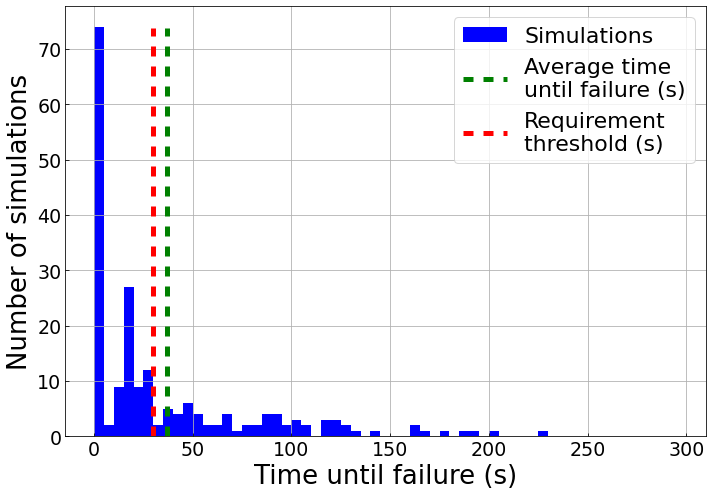

In [20]:
from matplotlib import pyplot as plt
import math

# Creating histogram for time until failure
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(t, bins = np.arange(0, 300, 5), color = 'b',label = 'Simulations')
plt.xlabel("Time until failure (s)", fontsize=26)
plt.ylabel("Number of simulations", fontsize=26)
ax.tick_params(labelsize=19, direction='in')

# Find average time until failure
mean = np.mean(t)
print("Average time until failure: ", mean)

# Plot average time until failure
ax.axvline(x = mean, ymin = 0, ymax = 0.95, linestyle = (0,(2,2)), color = 'g', linewidth = 5, label = 'Average time\nuntil failure (s)')

# Plot requirement of 30 seconds
ax.axvline(x = 30, ymin = 0, ymax = 0.95, color = 'r', linestyle = (0,(2,2)), linewidth = 5, label = 'Requirement\nthreshold (s)' % mean)

ax.legend(loc='best', fontsize = 22)
plt.grid()
plt.rcParams.update({'figure.autolayout': True})
fig.savefig('Time_Until_Failure2.png', facecolor='white', transparent=False)
# Show plot
plt.show()